In [43]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from transformers import BertTokenizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#configs
max_tokens = 20000
max_length = 1200
vocab_size_train = max_tokens
embedding_dim = 32

developing = False

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [44]:
sample_submission_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
train_data_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_from_comp = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

In [45]:
train, test = train_test_split(train_data_raw, test_size=0.2, random_state=21) #20% for test
train, val = train_test_split(train, test_size=0.1, random_state=21) # 10% for validation
train

targets=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

train_targets = train[targets]
val_targets = val[targets]
test_targets = test[targets]

train_targets_ds = tf.convert_to_tensor(train_targets)
val_targets_ds = tf.convert_to_tensor(val_targets)
test_targets_ds = tf.convert_to_tensor(test_targets)

train_text_only = tf.convert_to_tensor(train['full_text'])
val_text_only = tf.convert_to_tensor(val['full_text'])
test_text_only = tf.convert_to_tensor(test['full_text'])

## for submission 
all_train_targets = train_data_raw[targets]
all_train_targets_ds = tf.convert_to_tensor(all_train_targets)
all_train_text_only = tf.convert_to_tensor(train_data_raw['full_text'])

all_test_text_only = tf.convert_to_tensor(test_from_comp['full_text'])


In [46]:
# text_vectorization = layers.TextVectorization(
#     max_tokens=max_tokens,
#     output_mode="multi_hot"
# )

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

#use the dataset to index the dataset vocab via the adapt method
text_vectorization.adapt(train_text_only)

train_features_ds = text_vectorization(train_text_only)
val_features_ds = text_vectorization(val_text_only)
test_features_ds = text_vectorization(test_text_only)

#for submission
all_train_features_ds = text_vectorization(all_train_text_only)
all_test_features_ds = text_vectorization(all_test_text_only)


In [48]:
def get_model(max_tokens=max_tokens, hidden_dim=32):
    
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    embeddings = layers.Embedding(vocab_size_train, embedding_dim, name="embedding")(inputs)
    
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(embeddings)
    x = layers.Dropout(rate=0.5)(x)

    outputs = layers.Dense(6, activation=None)(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="mean_absolute_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError(
                name='root_mean_squared_error', dtype=None
            )]
    )
    return model


#train model and test
model = get_model()
model.summary()

if developing:

    callbacks = [
        keras.callbacks.ModelCheckpoint("model_one_hot_bidir_lstm.keras", save_best_only=True)
    ]
    hist = model.fit(
        x=train_features_ds,
        y=train_targets_ds,
        validation_data = (
            val_features_ds, val_targets_ds
        ),
        epochs=10,
        callbacks=callbacks,
        batch_size=16
    )

    model = keras.models.load_model("model_one_hot_bidir_lstm.keras")
    print(f"Test acc: {model.evaluate(test_features_ds, test_targets_ds, 1)}")


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 32)          640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 657,030
Trainable params: 657,030
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
176/176 [==============================] - 16s 75ms/step - loss: 1.1286 - root_mean_squared_error: 1.4822 - 

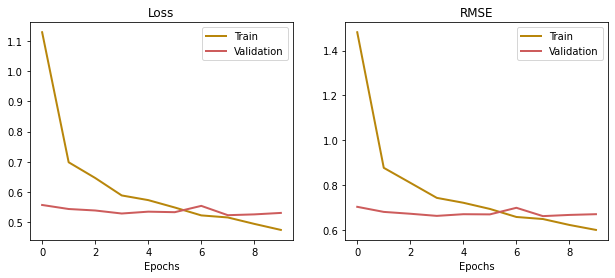

In [49]:
if developing:
    # grab history
    history = hist.history

    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)

    plt.plot(history['loss'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_loss'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('Loss');

    ax = fig.add_subplot(1, 3, 2)

    plt.plot(history['root_mean_squared_error'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_root_mean_squared_error'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('RMSE');


In [50]:
#
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embedding_w_lstm.keras", save_best_only=True)
]
hist = model.fit(
    x=all_train_features_ds,
    y=all_train_targets_ds,
    validation_data = None,
    epochs=10,
    callbacks=callbacks
)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 32)          640000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 657,030
Trainable params: 657,030
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
123/123 [==============================] - 12s 75ms/step - loss: 1.2648 - root_mean_squared_error: 1.6336
Epo

## Submission to contest

In [51]:
test_predictions = model.predict(all_test_features_ds)
test_predictions = pd.DataFrame(test_predictions)

test_from_comp['cohesion'] = test_predictions[0]
test_from_comp['syntax'] = test_predictions[1]
test_from_comp['vocabulary'] = test_predictions[2]
test_from_comp['phraseology'] = test_predictions[3]
test_from_comp['grammar'] = test_predictions[4]
test_from_comp['conventions'] = test_predictions[5]
test_from_comp

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,3.063609,2.928313,3.170742,3.023264,2.898668,2.993930
1,000BAD50D026,Do you think students would benefit from being...,2.761460,2.600988,2.802647,2.671698,2.523160,2.670390
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.200701,3.060711,3.327310,3.170163,3.056504,3.125745


In [52]:
res = test_from_comp.drop("full_text",axis=1)
res.to_csv("/kaggle/working/submission.csv",index=False)